In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from sklearn import preprocessing
from time import time

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [4]:
# Initialize variables required for the algorithm
# Best values according to paper

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 3.0                     # Lebesgue norm of the weights
rank = 7                                # ranking parameter, must be integer that is bigger or equal than 2

In [5]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [ ]:
# LOAD AND PREPARE MNIST DATA FOR UNSUPERVISED TRAINING

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")
#print(mat)

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data_mnist = M
print(f'Number of samples: {data_mnist.shape[0]}')
print(f'Number of features: {data_mnist.shape[1]}')

In [ ]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for MNIST

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_mnist = get_unsupervised_weights(data_mnist, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
#print(weights_mnist.shape)
#print(weights_mnist)

# Keep backups of these weights
weights_mnist_backup = weights_mnist
weights_mnist_frozen = weights_mnist

# TODO Maybe write these to file to keep?

In [ ]:
# SANITY CHECKS (for my sanity)

print(weights_mnist)
print()
print(weights_mnist_backup)
print()
print(weights_mnist_frozen)
print()

print(torch.all(weights_mnist.eq(weights_mnist_backup)))
print(torch.all(weights_mnist.eq(weights_mnist_frozen)))
print(torch.all(weights_mnist_frozen.eq(weights_mnist_backup)))

#print((weights_mnist==weights_mnist_backup).all())
#print((weights_mnist_frozen==weights_mnist_backup).all())

<IPython.core.display.Javascript object>


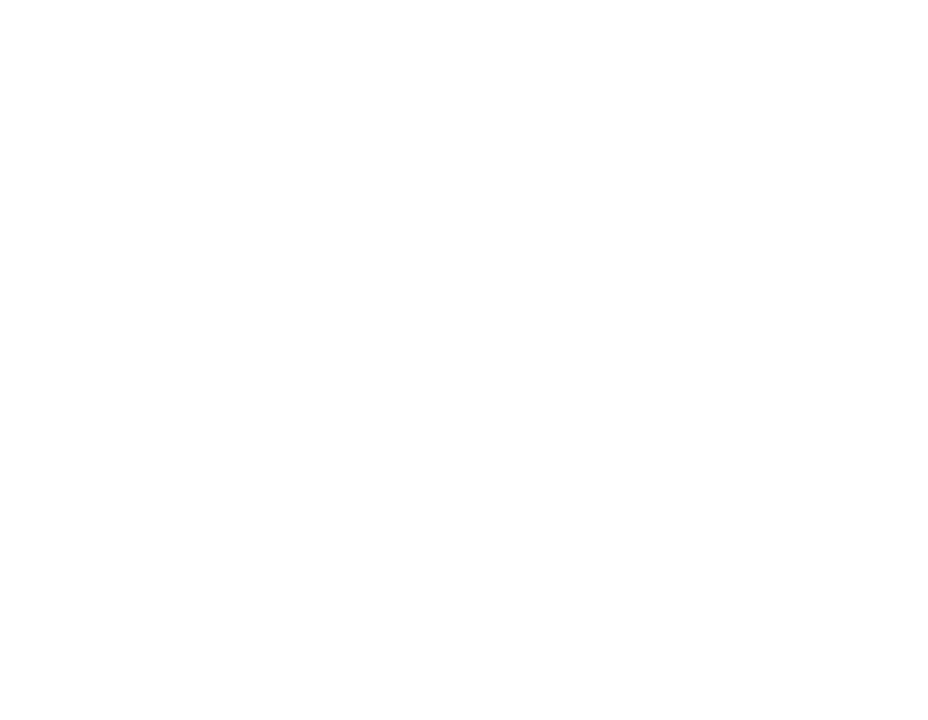

NameError: name 'weights_mnist' is not defined

In [6]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_mnist.cpu().numpy(), Kx, Ky)
print(weights_mnist.shape)
print("Fin")

In [ ]:
# DEFINE BioClassifier AND BioLoss CLASSES TO PERFORM BIO-PLAUSIBLE LEARNING

# REFERENCED FROM https://github.com/gatapia/unsupervised_bio_classifier

class BioCell(nn.Module):
    def __init__(self, Wui, beta, out_features):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        # TODO: Does this need to be transposed here?
        # Answer: NO! Because we are using F.linear in the forward pass rather than multiplying directly ourselves.
        # F.linear does the transpose internally.
        self.Wui = Wui
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):
        Wui_vi = F.linear(vi, self.Wui, None)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca

    
class BioCell2(nn.Module):
    def __init__(self, Wui, beta=0.1, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):        
        # Different from BioCell where we do matmul here directly rather than using nn.Linear to accomplish the same.
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca


class BioCell3(nn.Module):
    def __init__(self, Wui, n=4.5, beta=.01, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.n = n
        self.beta = beta
        # Below can be renamed to self.supervised to be similar to previous cells
        self.Sau = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vᵢ):
        # vᵢ = vᵢ.view(-1, 28, 28).transpose(1, 2).contiguous().view(-1, 28*28) # change vᵢ to be HxW for testing
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using custom RELU as in the paper
        hu = F.relu(Wui_vi) ** self.n
        Sau_hu = self.Sau(hu)
        ca = torch.tanh(self.beta * Sau_hu)
        return ca

    
class BioLoss(nn.Module):
    def __init__(self, m=6):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

    
class BioClassifier(nn.Module):
    def __init__(self, bio):
        super().__init__()
        self.bio = bio

    def forward(self, vi):
        ca = self.bio(vi)
        return F.log_softmax(ca, dim=-1)



In [ ]:
# RESET weights (for my sanity)

weights_mnist = weights_mnist_frozen

In [ ]:
# TRAIN USING BIOCLASSIFIER AND OBTAIN GENERALIZATION RESULTS
# Results: Accuracy of the network on the 10000 test images: 97.26 %

# REFERENCES: 
# - https://www.python-engineer.com/courses/pytorchbeginner/13-feedforward-neural-network/
# - https://github.com/gatapia/unsupervised_bio_classifier

# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot some sample data for sanity check
#examples = iter(test_loader)
#example_data, example_targets = examples.next()
#%matplotlib inline
#%matplotlib notebook
#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()


# 1) Design and init model
#model = BioClassifier(BioCell2(weights_mnist)).to(device)
model = BioClassifier(BioCell3(weights_mnist)).to(device)

# Print the named parameters to test that model initialised correctly. 
# Names parameter that requires grad should be only S.weight.
print(f'Printing named parameters for the generated BioClassifier model.')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
print()


# 2) Construct loss and optimizer
criterion = BioLoss(m=6)
#criterion = nn.NLLLoss()
supervised_learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 


# 3) Train the model - training loop
n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')
n_supervised_epochs = 300
print(f'n_supervised_epochs: {n_supervised_epochs}')

print('Start training...')
for epoch in range(n_supervised_epochs):
    print()
    for i, (images, labels) in enumerate(train_loader):
        
        # origin images shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # predict = forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')

# Test the model
# In test phase, we don't need to compute gradients (helpful for memory efficiency) so use torch.no_grad()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

# OUTPUT
# Epoch [300/300], Step [600/600], Loss: 46022.9062
# Completed training.
# Accuracy of the network on the 10000 test images: 97.26 %

In [ ]:
##### ------ THIS IS THE END OF MNIST WORK -------

In [ ]:
# RESET weights (for my sanity)

weights_mnist = weights_mnist_frozen

In [ ]:
# IGNITE
# REFERENCE: https://pytorch.org/ignite/quickstart.html, https://github.com/gatapia/unsupervised_bio_classifier

#def run_test(train_loader, test_loader, model, epochs, batch_size=64, lr=1e-3, verbose=0, loss=None):
def run_test(train_X, train_y, test_X, test_y, model, epochs, batch_size=64, lr=1e-3, verbose=0, loss=None):
    start = time()
    
    train_ds = torch.utils.data.TensorDataset(train_X, train_y)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_ds = torch.utils.data.TensorDataset(test_X, test_y)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if loss is None: 
        loss = F.nll_loss
    
    trainer = create_supervised_trainer(model, optimizer, loss, device=device)
    
    metrics = {
        'accuracy': Accuracy(),
        'nll': Loss(loss)   # TODO rename to 'loss'
    }
    
    evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
    
    # TODO rewrite print styles into my format
    
    @trainer.on(Events.ITERATION_COMPLETED(every=100))
    def log_training_loss(trainer):
        print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']
        print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
              .format(trainer.state.epoch, avg_accuracy, avg_nll))
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(test_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']
        print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
              .format(trainer.state.epoch, avg_accuracy, avg_nll))
    
    @trainer.on(Events.COMPLETED)
    def log_completed_validation_results(trainer):
        evaluator.run(test_loader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']
        print("Final Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f} Took: {:.0f}s"
              .format(trainer.state.epoch, avg_accuracy, avg_nll, time() - start))

    trainer.run(train_loader, max_epochs=epochs) 
    

In [ ]:
# https://github.com/gatapia/unsupervised_bio_classifier

def get_data(data_type):
    mat = scipy.io.loadmat('mnist_all.mat')
    X=torch.zeros((0, 28 * 28), dtype=torch.float)
    y=torch.zeros(0, dtype=torch.long)
    for i in range(10): 
        X_i = torch.from_numpy(mat[data_type + str(i)].astype(np.float)).float()
        X = torch.cat((X, X_i))
        y_i = torch.full(size=(len(X_i),), fill_value=i, dtype=torch.long)
        y = torch.cat((y, y_i))
    return X / 255.0, y

In [ ]:
(train_X, train_y), (test_X, test_y) = get_data('train'), get_data('test')
print('train_data:', train_X.shape, train_y.shape)
print('test_data:', test_X.shape, test_y.shape)

In [ ]:
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


print('\nBioClassifier w/ BioCell3 Model w/ BioLoss')
model = BioClassifier(BioCell3(weights_mnist)).to(device)
#run_test(train_X, train_y, test_X, test_y, model, 300, batch_size=3584, lr=1e-4, loss=BioLoss(m=6))
run_test(train_X, train_y, test_X, test_y, model, 300, batch_size=1024, lr=1e-4, loss=BioLoss(m=6))
#run_test(train_loader, test_loader, model, 300, batch_size=3584, lr=1e-4, loss=BioLoss(m=6))

In [ ]:
# BELOW IS WORK FOR CIFAR-10
# ALL WORK IN PROGRESS

In [15]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])
transform_grayscale = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_dataset_grayscale = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_grayscale)

test_dataset_grayscale = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_grayscale)


cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [17]:
# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([1, 1, 32, 32])
torch.Size([1])


<IPython.core.display.Javascript object>


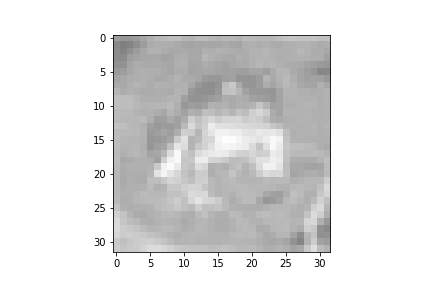

tensor([[[[0.2392, 0.1765, 0.1882,  ..., 0.5373, 0.5098, 0.5059],
          [0.0745, 0.0000, 0.0392,  ..., 0.3725, 0.3529, 0.3686],
          [0.0941, 0.0353, 0.1216,  ..., 0.3529, 0.3569, 0.3137],
          ...,
          [0.6784, 0.6039, 0.6157,  ..., 0.5255, 0.1412, 0.1490],
          [0.5725, 0.5059, 0.5647,  ..., 0.6000, 0.2706, 0.2353],
          [0.5922, 0.5373, 0.5765,  ..., 0.7412, 0.4863, 0.3882]]]])
tensor([6])


In [18]:
# Display some random training images in grayscale
train_loader_grayscale = torch.utils.data.DataLoader(train_dataset_grayscale, batch_size=1)
dataiter_grayscale = iter(train_loader_grayscale)
image, label = dataiter_grayscale.next()
print(image.shape)
print(label.shape)
%matplotlib inline
%matplotlib notebook
imshow(torchvision.utils.make_grid(image))

print(image)
print(label)

torch.Size([1, 3, 32, 32])
torch.Size([1])


<IPython.core.display.Javascript object>


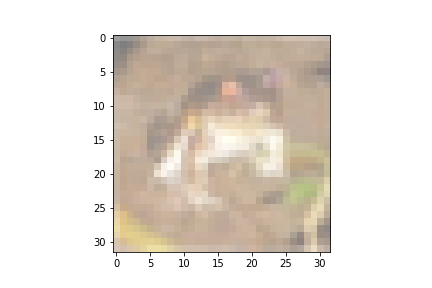

tensor([[[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ..., 0

In [19]:
# Display some random training images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
dataiter = iter(train_loader)
image, label = dataiter.next()
print(image.shape)
print(label.shape)
%matplotlib inline
%matplotlib notebook
imshow(torchvision.utils.make_grid(image))

print(image)
print(label)

In [ ]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for CIFAR

# WORK IN PROGRESS

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_cifar = get_unsupervised_weights(data_cifar, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_cifar.shape)
print(weights_cifar)

In [ ]:
# Draw CIFAR-10 weights/feature detectors generated by unsupervised bio algo

# WORK IN PROGRESS

def draw_weights(synapses, Kx, Ky):
    print(synapses)
    print(synapses.shape) # (100, 3072)
    yy=0
    HM=np.zeros((32*Ky,32*Kx,3))
    print(HM.shape) # (320, 320, 3)
    for y in range(Ky):
        for x in range(Kx):

            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(3,32,32)

            #print(synapses.shape)   # (100, 3072)
            #print(shit.shape)          # (3072,)
            #print(shit_reshape.shape)  # (3, 32, 32)

            #HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            HM[y*32:(y+1)*32,x*32:(x+1)*32,:]=synapses[yy,:].reshape(32,32,3)

            #HM[z, y*32:(y+1)*32,x*32:(x+1)*32]=synapses[yy,:].reshape(3,32,32)
            yy += 1
    print("Done with the fucking loop")
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM[:,:,0],cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_cifar, Kx, Ky)
print("Fin")

In [ ]:
# USE THIS BLOCK FOR DEBUGGING PURPOSES ONLY !!

# Contains data loading and whole bio learning in one block of code.
# Plots the feature detectors at the end of training.

# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
num_samples = data.shape[0]   # 60000 training and validation examples. Number of samples
num_features = data.shape[1]  # number of pixels for each image. 28x28. Also: num_samples, num_pixels..

# ------------------------------------------------------------------------------------------------------------

# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Initialize weights to be values drawn from gaussian distribution.
synapses = np.random.normal(mu, sigma, (n_hidden, N)).astype(np.float32)
weights = torch.from_numpy(synapses).to(device)

# The external loop runs over epochs
for epoch in range(n_epochs):
    eps = learning_rate * (1 - epoch / n_epochs)
    #print(f'epoch learning rate: {eps}')
    
    # Scramble the images and values. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    random_permutation_samples = np.random.permutation(num_samples)
    shuffled_epoch_data = data[random_permutation_samples,:]
    
    # Internal loop runs over minibatches    
    for i in range(num_samples // batch_size):        
        # For every minibatch the overlap with the data (tot_input) is 
        # calculated for each data point and each hidden unit.
        mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
        mini_batch = torch.from_numpy(mini_batch).to(device)           
        mini_batch = torch.transpose(mini_batch, 0, 1)
        
        sign = torch.sign(weights)            
        W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
        # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
        tot_input_torch = torch.mm(W, mini_batch)
                
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
        y_torch = torch.argsort(tot_input_torch, dim=0)            
        yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
        yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
        yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength
        
        # The variable ds is the right hand side of Eq 3        
        xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
        xx_torch = xx_torch.unsqueeze(1)                    
        xx_torch = xx_torch.repeat(1, num_features)
        ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)
        
        # Update weights
        # The weights are updated after each minibatch in a way so that the largest update 
        # is equal to the learning rate eps at that epoch.        
        nc_torch = torch.max(torch.abs(ds_torch))
        if nc_torch < precision: 
            nc_torch = precision            
        weights += eps*(ds_torch/nc_torch)
        
        #if (i+1) % 100 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')
        
    print (f'Epoch [{epoch+1}/{n_epochs}]')
    #draw_weights(weights.numpy(), Kx, Ky)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights.cpu().numpy(), Kx, Ky)
print("Fin")

In [ ]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_mnist.cpu().numpy(), Kx, Ky)
print(weights_mnist.shape)
print("Fin")